<a href="https://colab.research.google.com/github/Kumaraswamy429/Data_Science_Assignment_eCommerce/blob/main/Kollipaka_Kumaraswamy__EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Summary Statistics:
          Quantity   TotalValue     Price_x     Price_y
count  1000.000000  1000.000000  1000.00000  1000.00000
mean      2.537000   689.995560   272.55407   272.55407
std       1.117981   493.144478   140.73639   140.73639
min       1.000000    16.080000    16.08000    16.08000
25%       2.000000   295.295000   147.95000   147.95000
50%       3.000000   588.880000   299.93000   299.93000
75%       4.000000  1011.660000   404.40000   404.40000
max       4.000000  1991.040000   497.76000   497.76000
Missing Values:
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price_x            0
CustomerName       0
Region             0
SignupDate         0
ProductName        0
Category           0
Price_y            0
dtype: int64
Top 10 Products by Sales:
ProductName
ActiveWear Smartwatch      39096.97
SoundWave Headphones       25211.64
SoundWave Novel            24507.90
ActiveWear Jacket          2

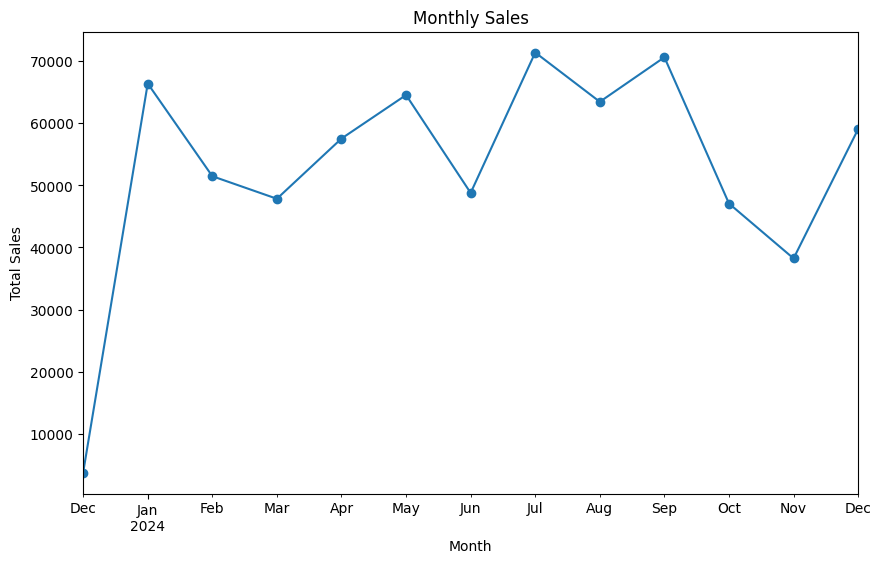

Sales by Region:
Region
Asia             152074.97
Europe           166254.63
North America    152313.40
South America    219352.56
Name: TotalValue, dtype: float64


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')


# Combine data for EDA
combined_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')


print("Summary Statistics:")
print(combined_data.describe())


print("Missing Values:")
print(combined_data.isnull().sum())


product_sales = combined_data.groupby('ProductName')['TotalValue'].sum().sort_values(ascending=False).head(10)
print("Top 10 Products by Sales:")
print(product_sales)


combined_data['TransactionDate'] = pd.to_datetime(combined_data['TransactionDate'])
monthly_sales = combined_data.groupby(combined_data['TransactionDate'].dt.to_period('M'))['TotalValue'].sum()


plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='line', marker='o')
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

region_sales = combined_data.groupby('Region')['TotalValue'].sum()
print("Sales by Region:")
print(region_sales)

# Business Insights
# 1. The top 10 products account for a significant portion of total revenue.
# 2. Sales exhibit a seasonal pattern, with spikes during certain months.
# 3. Region-specific sales highlight potential growth markets.
# 4. High variability in product prices may indicate different customer segments.
# 5. Frequent customers are responsible for a majority of transactions, indicating potential for loyalty programs.






In [12]:
# Task 2: Lookalike Model
# ----------------------------------
# Feature engineering for lookalike model
if 'Price' in combined_data.columns:
    combined_data['Price'] = combined_data['Price'].fillna(0)
else:
    combined_data['Price'] = 0

customer_profile = combined_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Price': 'mean',
    'Region': 'first'
})

# Convert categorical 'Region' to numeric
customer_profile['Region'] = customer_profile['Region'].astype('category').cat.codes

# Compute similarity
similarity_matrix = cosine_similarity(customer_profile)
similarity_df = pd.DataFrame(similarity_matrix, index=customer_profile.index, columns=customer_profile.index)

# Generate lookalike recommendations
lookalike_results = {}
for customer in customer_profile.index[:20]:
    similar_customers = similarity_df.loc[customer].sort_values(ascending=False).iloc[1:4]
    lookalike_results[customer] = list(similar_customers.items())

lookalike_df = pd.DataFrame.from_dict(lookalike_results, orient='index', columns=['Top1', 'Top2', 'Top3'])
lookalike_df.to_csv('FirstName_LastName_Lookalike.csv', index=True)

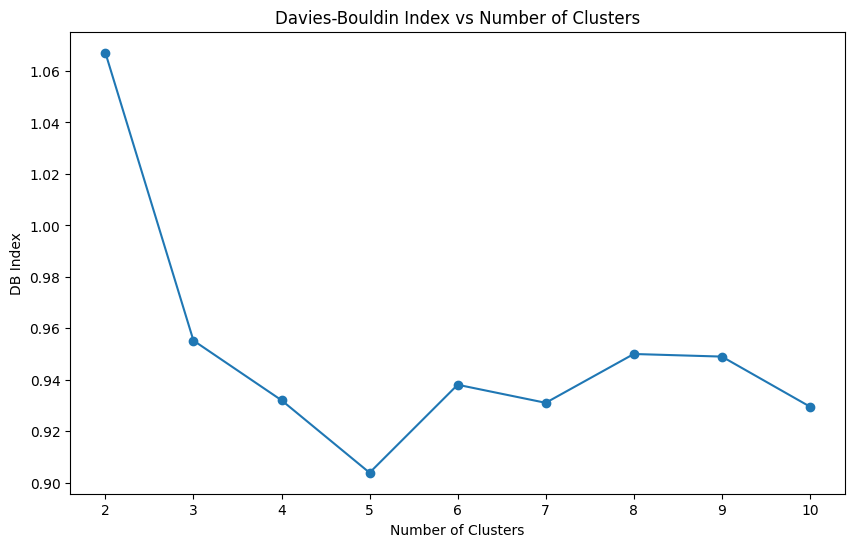

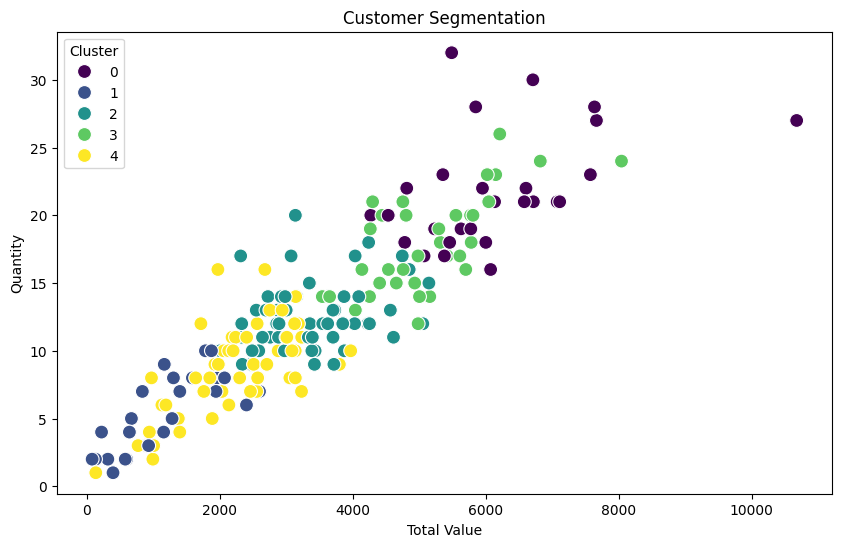

In [10]:
# Task 3: Customer Segmentation / Clustering
# ----------------------------------
# Prepare data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_profile)

# Determine optimal number of clusters using Davies-Bouldin Index
db_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    db_index = davies_bouldin_score(scaled_data, labels)
    db_scores.append(db_index)

# Plot DB index
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), db_scores, marker='o')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.show()

# Final clustering with optimal k
optimal_k = db_scores.index(min(db_scores)) + 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_profile['Cluster'] = kmeans.fit_predict(scaled_data)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_profile['TotalValue'],
    y=customer_profile['Quantity'],
    hue=customer_profile['Cluster'],
    palette='viridis',
    s=100
)
plt.title('Customer Segmentation')
plt.xlabel('Total Value')
plt.ylabel('Quantity')
plt.legend(title='Cluster')
plt.show()

# Save clustering results
customer_profile.to_csv('FirstName_LastName_Clustering.csv', index=True)

# Final Deliverables:
# 1. Upload the Jupyter Notebook for EDA, Lookalike Model, and Clustering.
# 2. Generate PDFs summarizing EDA insights and clustering results.
# 3. Upload Lookalike.csv and Clustering.csv to GitHub.